Group Members: Dhruv, Rohan, Sarthak, Uday

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
sys.path.append(os.getcwd() + '/modules')
import seaborn as sns

# from modules.cross_validation import Pipeline, CustomCrossValidation
# from modules.directional_change import *
# from modules.hidden_markov_model import make_regime_plots
# from modules.logistic_regression import do_all_LR
# from modules.MixtureModels import *
# from modules.NaiveBayesClassifier import *
# from modules.svm import do_all_SVM
# from modules.timeseries import *
# from modules.trading_strategy import *
import matplotlib.patches as mpatches

import warnings
warnings.filterwarnings('ignore')

# plt.style.use('seaborn')
sns.set_theme()

# Experiments

Put self-contained code here for different experiments run. Easier to put in the report that way.

In [3]:
import nltk
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

FOMC_STOP_WORDS = ["federal", "reserve", "board", "meeting", "committee", "minutes", "members"]
def custom_stop_words():
    stop_words = list(ENGLISH_STOP_WORDS) + FOMC_STOP_WORDS
    return stop_words

def join_tokens(tokens):
    return " ".join(tokens)


def remove_stop_words(tokens):
    stop_words = custom_stop_words()
    tokens = [word.lower() for word in tokens if word.isalpha()]
    result = [w.lower() for w in tokens if w.lower() not in stop_words]
    return result

In [7]:
def tokenize_data(df):
    df['tokens'] = df.text.apply(nltk.word_tokenize)
    df["tokens_wo_stop"] = df.tokens.apply(remove_stop_words)
    df["new_text"] = df.tokens_wo_stop.apply(join_tokens)
    return df

def manual_tf_idf(text: pd.Series):
    """
    This function manually computes the TF-IDF values for the given column of
    documents, in order to avoid the incorrect computations performed by
    sklearn's native implementation.

    @param text(pd.Series): the (n, 1) column of n documents for which TF-IDF
                            is being computed
    @returns tf_idf_df(np.ndarray): the (n, n_words) representing TF-IDF values
    """
    # Get number of documents
    n_docs = text.shape[0]
    from sklearn.feature_extraction.text import CountVectorizer
    # Generate bag-of-words matrix
    def_vectorizer = CountVectorizer(token_pattern='[a-zA-Z]+')
    word_bow_matrix = def_vectorizer.fit_transform(text)
    word_bow_df = pd.DataFrame(
        word_bow_matrix.toarray(),
        columns=def_vectorizer.get_feature_names_out()
    )

    # Create TF matrix
    tf_df = word_bow_df / word_bow_df.sum(axis=1).values.reshape(n_docs, 1)

    # Compute IDF values
    idf = np.log(n_docs / (word_bow_df / word_bow_df.values).sum(axis=0))

    # Manually create TF-IDF matrix
    tfidf_df = tf_df * idf

    return tfidf_df

def clean_text(text: str):
    text = text.lower()
    split_by = ''
    if 'the manager' in text and 'unanimous' in text:
        if text.index('the manager') > text.index('unanimous'):
            split_by = 'unanimous'
        else:
            split_by = 'the manager'
    elif 'the manager' in text:
        split_by = 'the manager'
    elif 'unanimous' in text:
        split_by = 'unanimous'
    else:
        raise ValueError('Neither in text!')

    return text.split(split_by)[1]

In [8]:
fomc_data = pd.read_csv("fomc_documents.csv")
fomc_data.meeting_date = pd.to_datetime(fomc_data.meeting_date)
fomc_data = fomc_data[fomc_data.document_kind.isin(['historical_minutes', 'minutes', 'minutes_of_actions'])]
fomc_data['meeting_year'] = fomc_data.meeting_date.dt.year
fomc_data = fomc_data[fomc_data.meeting_year >= 1985]
fomc_data.text = fomc_data.text.apply(clean_text)
fomc_data.head(1)
fomc_data = tokenize_data(fomc_data)

In [9]:
test_data = fomc_data[fomc_data["meeting_date"] > datetime(2019, 12, 31)]
train_data = fomc_data[fomc_data["meeting_date"] <= datetime(2019, 12, 31)]

In [10]:
from gensim.corpora import Dictionary
def generate_gensim_input(df, dict_gensim_statements=None):
  gensim_statements = df["tokens_wo_stop"] .tolist()
  if dict_gensim_statements is None: 
    dict_gensim_statements = Dictionary(gensim_statements)
  bow_gensim_statements = [dict_gensim_statements.doc2bow(d) for d in gensim_statements]
  return gensim_statements, dict_gensim_statements, bow_gensim_statements

In [11]:
# !pip install gensim# !pip install gensim
import gensim
gensim_statements, dict_gensim_statements, bow_gensim_statements = generate_gensim_input(train_data)
test_gensim_statements, _, test_bow_gensim_statements = generate_gensim_input(test_data, dict_gensim_statements)

In [12]:
from gensim.models import TfidfModel
from gensim.models.nmf import Nmf
from gensim.models.coherencemodel import CoherenceModel

tfidf_model = TfidfModel(bow_gensim_statements)
tfidf_statements = tfidf_model[bow_gensim_statements]
test_tfidf_statements = tfidf_model[test_bow_gensim_statements]


In [13]:
from gensim.matutils import corpus2dense, corpus2csc
def convert_to_dense_tfidf_matrix( bow, num_docs, num_terms, tfidf_model=None):
  if tfidf_model is None: 
    tfidf_model = TfidfModel(bow)
  tfidf_statements = tfidf_model[bow]  
  corpus_tfidf_dense = corpus2dense(tfidf_statements, num_terms, num_docs)
  return tfidf_model, corpus_tfidf_dense.T


In [14]:
num_terms = len(dict_gensim_statements.keys())
tfidf_train, corpus_tfidf_dense = convert_to_dense_tfidf_matrix(bow_gensim_statements, len(gensim_statements), num_terms)
_, test_corpus_dense = convert_to_dense_tfidf_matrix(test_bow_gensim_statements, len(test_gensim_statements), num_terms, tfidf_model=tfidf_train)

In [28]:
from topic_modeling import TopicModel
topicmod = TopicModel(tfidf_statements, dict_gensim_statements, gensim_statements)
topicmod.fit()

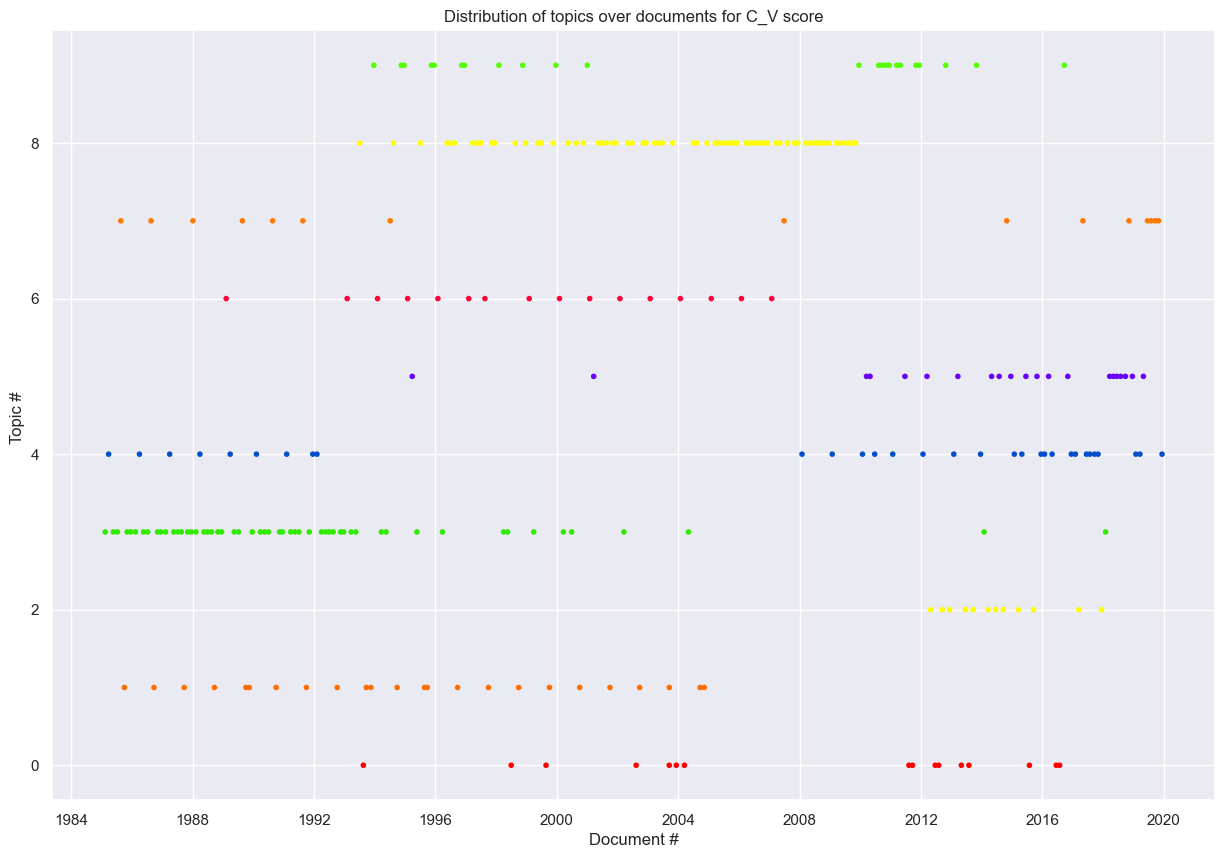

In [29]:
fig, ax =plt.subplots(1, figsize=(15, 10))
ax.scatter(y=topicmod.topic_mat, x=train_data["meeting_date"], marker=".", c=topicmod.topic_mat, cmap="prism")
ax.set_xlabel("Document #")
ax.set_ylabel("Topic # ")
plt.title("Distribution of topics over documents for C_V score")
plt.show()

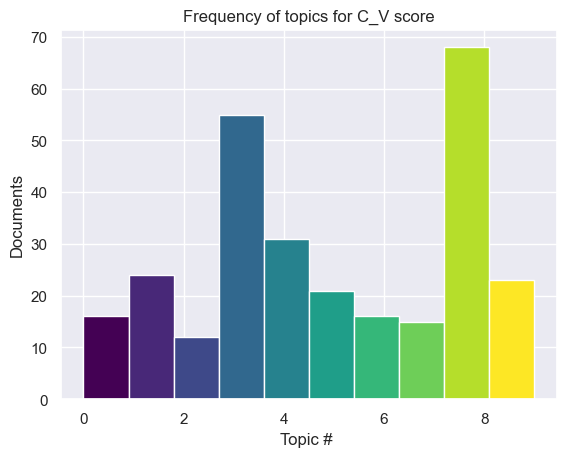

In [30]:
# fig, ax =plt.subplots(1, figsize=(15, 10))
# ax.hist(topicmod.topic_mat)

fig, ax = plt.subplots()
counts, bins, patches = ax.hist(topicmod.topic_mat, bins=10)

# Use a colormap
cmap = plt.get_cmap('viridis')
colors = cmap(np.linspace(0, 1, len(patches)))

for i, patch in enumerate(patches):
    patch.set_facecolor(colors[i])
ax.set_ylabel("Documents")
ax.set_xlabel("Topic # ")
plt.title("Frequency of topics for C_V score")
plt.show()

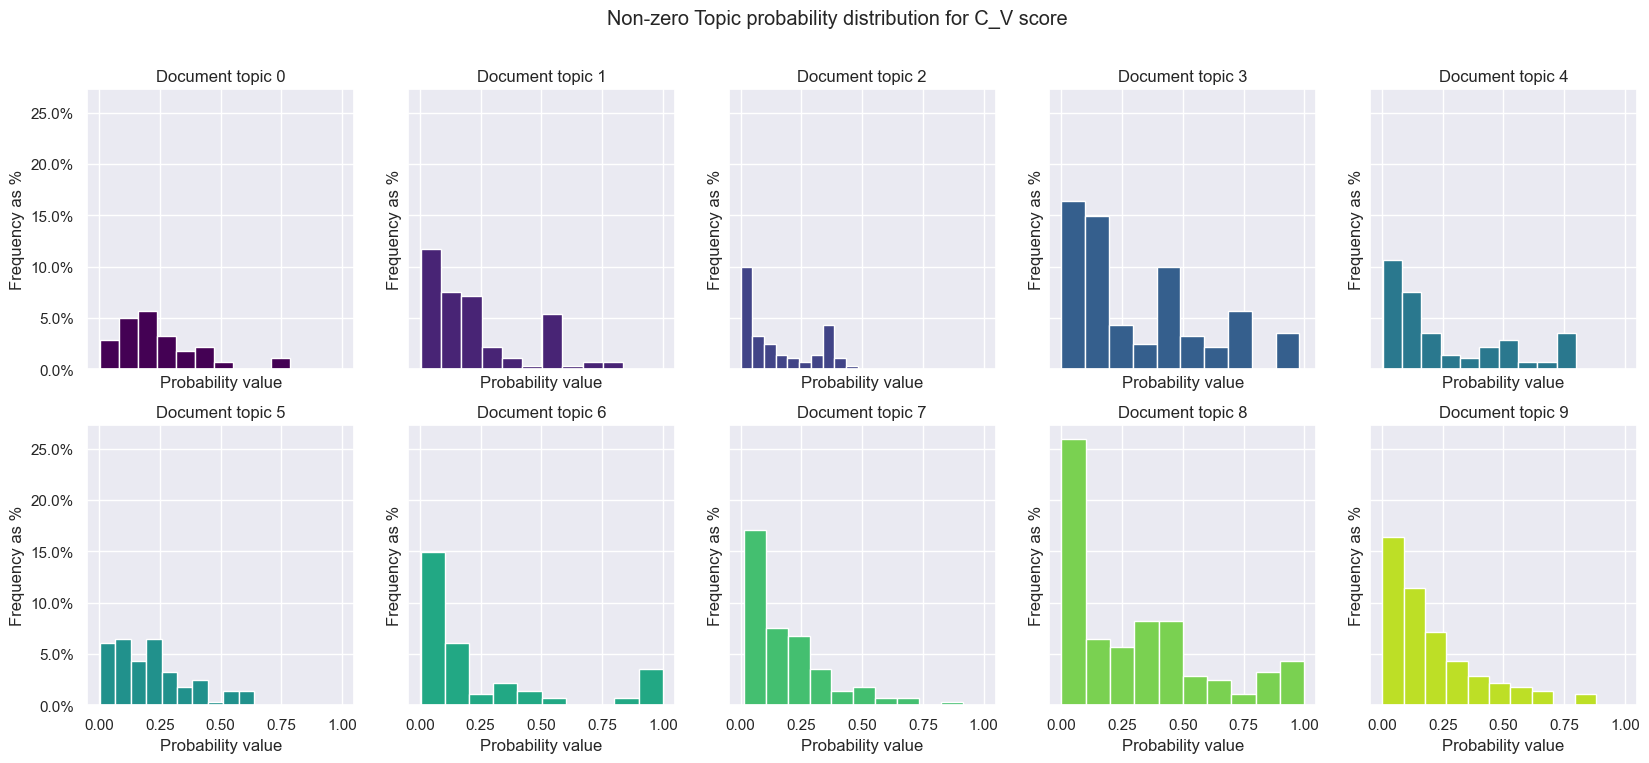

In [32]:
from matplotlib.ticker import PercentFormatter
import matplotlib.cm as cm

fig, ax = plt.subplots(2, 5, figsize=(20, 8),sharey=True, sharex=True)
k = 0
cmap = cm.get_cmap('viridis')
for i in range(2):
    for j in range(5):
        df = topicmod.doc_mat[:, k][topicmod.doc_mat[:, k].nonzero()]
        ax[i, j].hist(df, weights= np.ones_like(df)/len(topicmod.doc_mat[:,k]), color=cmap(k/10))
        ax[i, j].set_title("Document topic " + str(k))
        ax[i, j].set_xlabel("Probability value")
        ax[i, j].set_ylabel("Frequency as %")
        k=k+1
        ax[i, j].yaxis.set_major_formatter(PercentFormatter(1))
plt.suptitle("Non-zero Topic probability distribution for C_V score")
plt.show()


In [37]:
print("Top 10 words for topics")
topicmod.cv_model.show_topics(num_words=10)

Top 10 words for topics


[(0,
  '0.031*"june" + 0.011*"inflation" + 0.009*"economic" + 0.009*"labor" + 0.008*"policy" + 0.007*"pace" + 0.007*"conditions" + 0.006*"participants" + 0.006*"growth" + 0.006*"quarter"'),
 (1,
  '0.067*"august" + 0.036*"september" + 0.018*"april" + 0.013*"s" + 0.009*"inflation" + 0.009*"participants" + 0.008*"business" + 0.008*"selection" + 0.008*"agency" + 0.007*"obligations"'),
 (2,
  '0.027*"participants" + 0.021*"projections" + 0.018*"financial" + 0.017*"rate" + 0.017*"percent" + 0.016*"inflation" + 0.014*"domestic" + 0.011*"october" + 0.010*"appropriate" + 0.009*"unemployment"'),
 (3,
  '0.089*"taken" + 0.081*"actions" + 0.064*"march" + 0.057*"february" + 0.056*"approved" + 0.052*"held" + 0.033*"vote" + 0.021*"chairman" + 0.018*"required" + 0.016*"august"'),
 (4,
  '0.014*"deputy" + 0.011*"secretary" + 0.011*"assistant" + 0.011*"counsel" + 0.010*"economist" + 0.010*"rate" + 0.009*"general" + 0.009*"rates" + 0.008*"continued" + 0.008*"policy"'),
 (5,
  '0.018*"soma" + 0.013*"infl

In [41]:
import warnings
warnings.filterwarnings(action="ignore")
um_topicmod = TopicModel(tfidf_statements, dict_gensim_statements, gensim_statements, cv_score="u_mass")
um_topicmod.fit()

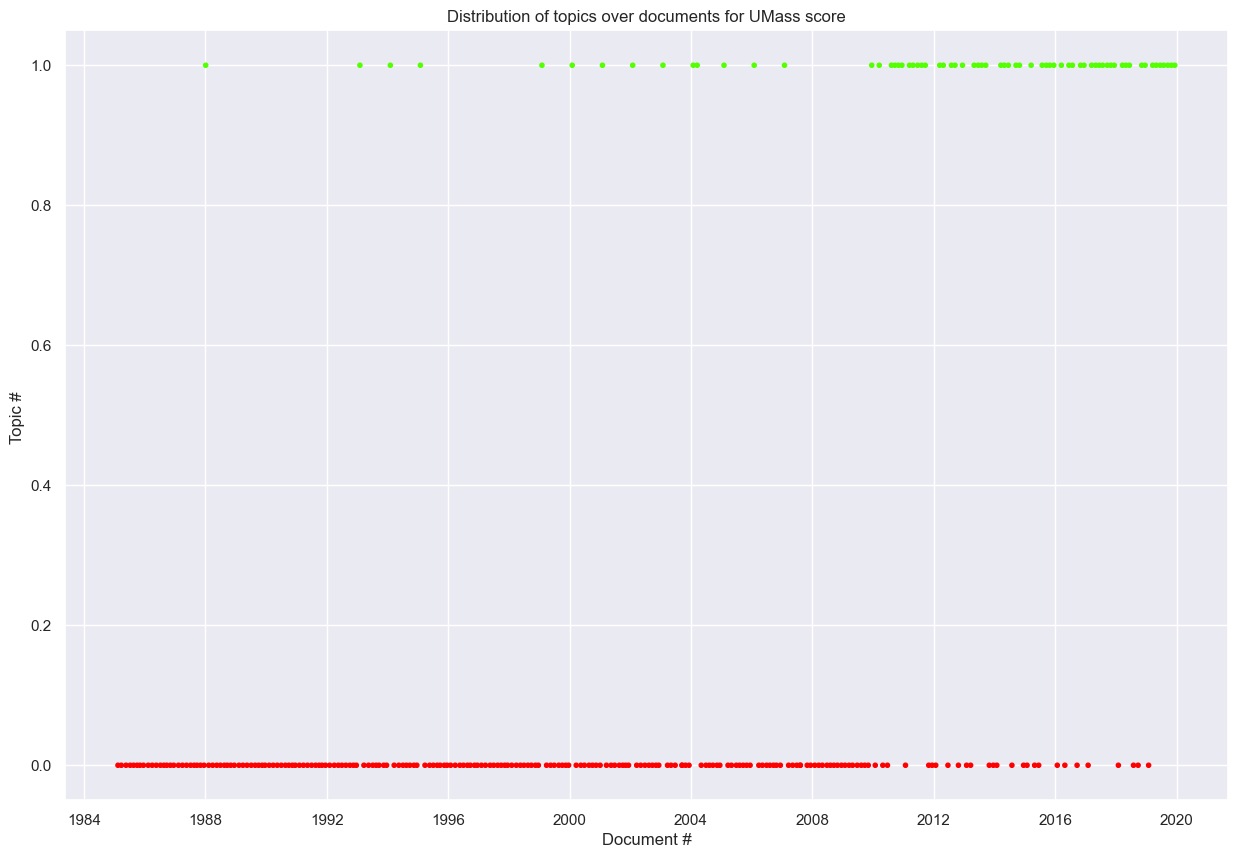

In [43]:
fig, ax =plt.subplots(1, figsize=(15, 10))
ax.scatter(y=um_topicmod.topic_mat, x=train_data["meeting_date"], marker=".",c=um_topicmod.topic_mat, cmap="prism")
ax.set_xlabel("Document #")
ax.set_ylabel("Topic # ")
plt.title("Distribution of topics over documents for UMass score")
plt.show()

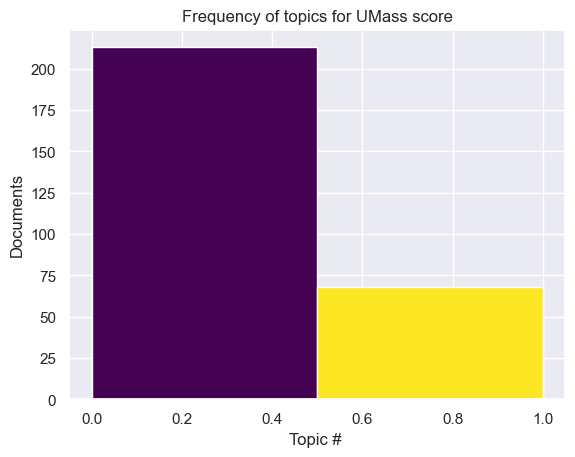

In [45]:
fig, ax = plt.subplots()
counts, bins, patches = ax.hist(um_topicmod.topic_mat, bins=2)

# Use a colormap
cmap = plt.get_cmap('viridis')
colors = cmap(np.linspace(0, 1, len(patches)))

for i, patch in enumerate(patches):
    patch.set_facecolor(colors[i])
ax.set_ylabel("Documents")
ax.set_xlabel("Topic # ")
plt.title("Frequency of topics for UMass score")
plt.show()

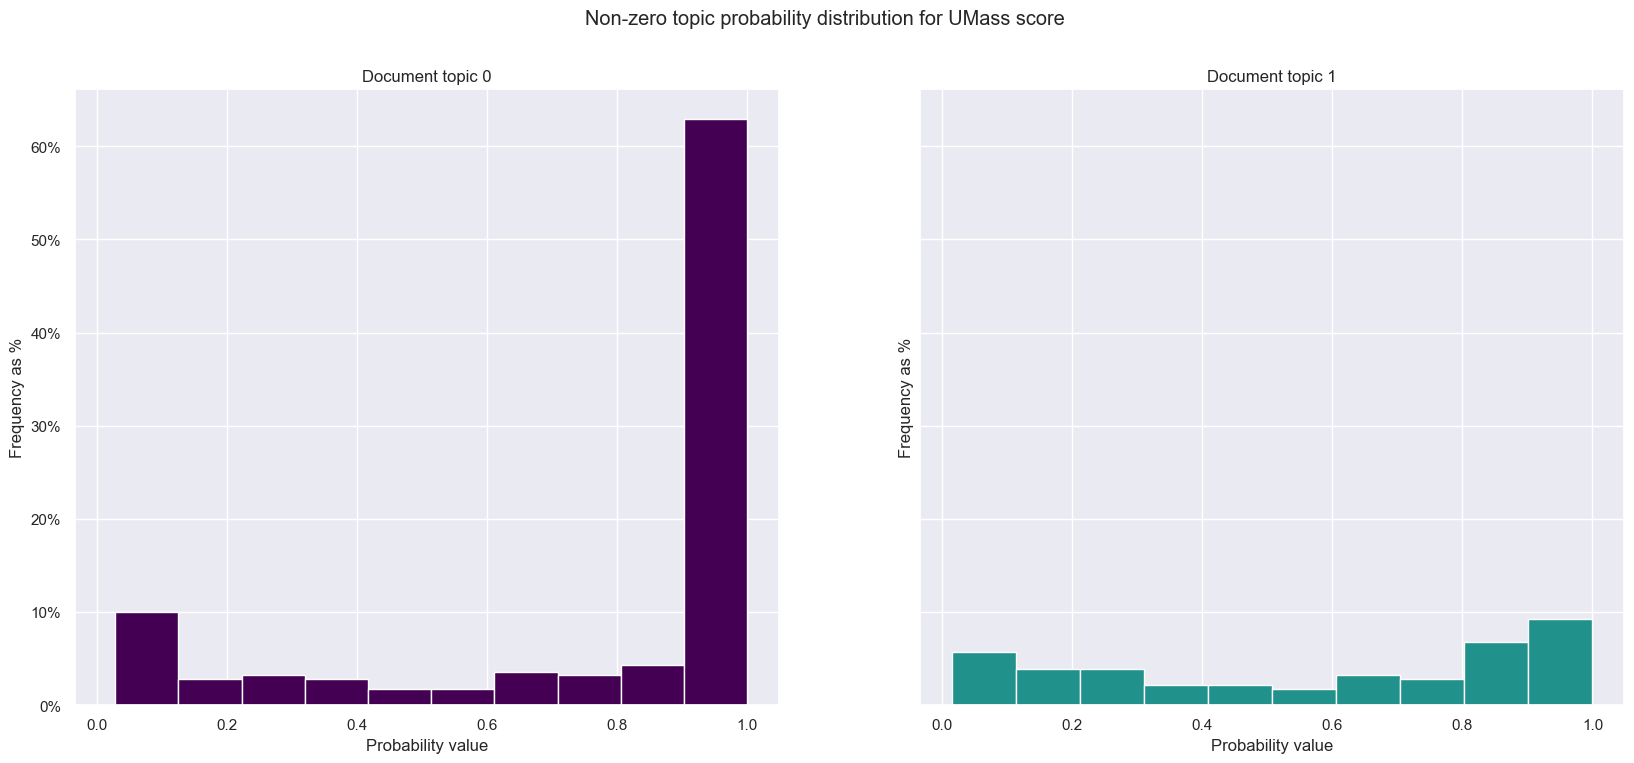

In [46]:
from matplotlib.ticker import PercentFormatter

fig, ax = plt.subplots(1, 2, figsize=(20, 8),sharey=True, sharex=True)
cmap = cm.get_cmap('viridis')
k = 0
for j in range(2):
        df = um_topicmod.doc_mat[:, k][um_topicmod.doc_mat[:, k].nonzero()]
        ax[j].hist(df, weights= np.ones_like(df)/len(um_topicmod.doc_mat[:,k]), color=cmap(k/2))
        ax[j].set_title("Document topic " + str(k))
        ax[j].set_xlabel("Probability value")
        k=k+1
        ax[j].yaxis.set_major_formatter(PercentFormatter(1))
        ax[j].set_ylabel("Frequency as %")
plt.suptitle("Non-zero topic probability distribution for UMass score")
plt.show()


In [48]:
um_topicmod.cv_model.show_topics(num_words=10)

[(0,
  '0.017*"foreign" + 0.014*"recent" + 0.014*"account" + 0.012*"taken" + 0.012*"reported" + 0.012*"markets" + 0.011*"actions" + 0.011*"developments" + 0.011*"period" + 0.010*"approved"'),
 (1,
  '0.012*"participants" + 0.012*"inflation" + 0.011*"rate" + 0.009*"s" + 0.009*"economic" + 0.008*"policy" + 0.007*"securities" + 0.007*"percent" + 0.005*"funds" + 0.005*"growth"')]

<div style="page-break-after: always;"></div>

In [50]:
import pyLDAvis
topic_term_dists = topicmod.cv_model.get_topics()  # transpose to make shape (num_terms, num_topics)
doc_topic_dists = topicmod.doc_mat# cv_model.get_document_topics(topicmod.tfidf_mat, minimum_probability=0)
# doc_topic_dists = [[tup[1] for tup in lst] for lst in doc_topic_dists]  # convert list of tuples to just list
doc_lengths = [len(doc) for doc in gensim_statements]
vocab = list(dict_gensim_statements.token2id.keys())
term_frequency = dict_gensim_statements.cfs

# Use pyLDAvis
vis_data = pyLDAvis.prepare(
    topic_term_dists=topic_term_dists,
    doc_topic_dists=doc_topic_dists,
    doc_lengths=doc_lengths,
    vocab=vocab,
    term_frequency=list(term_frequency.values())
)

print("Intertopic distance map for C_V Score\n\n")
pyLDAvis.display(vis_data)

Intertopic distance map for C_V Score




In [51]:
topic_term_dists = um_topicmod.cv_model.get_topics()  # transpose to make shape (num_terms, num_topics)
doc_topic_dists = um_topicmod.doc_mat# cv_model.get_document_topics(topicmod.tfidf_mat, minimum_probability=0)
# doc_topic_dists = [[tup[1] for tup in lst] for lst in doc_topic_dists]  # convert list of tuples to just list
doc_lengths = [len(doc) for doc in gensim_statements]
vocab = list(dict_gensim_statements.token2id.keys())
term_frequency = dict_gensim_statements.cfs

# Use pyLDAvis
vis_data = pyLDAvis.prepare(
    topic_term_dists=topic_term_dists,
    doc_topic_dists=doc_topic_dists,
    doc_lengths=doc_lengths,
    vocab=vocab,
    term_frequency=list(term_frequency.values())
)
print("Intertopic distance map for UMass score\n\n")
pyLDAvis.display(vis_data)

Intertopic distance map for UMass score


